In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

In [75]:
train_df = pd.read_csv("C:/Users/Nites/Downloads/Disease diagnosis mini project/train-small.csv")
valid_df = pd.read_csv("C:/Users/Nites/Downloads/Disease diagnosis mini project/valid-small.csv")

test_df = pd.read_csv("C:/Users/Nites/Downloads/Disease diagnosis mini project/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [76]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Make use of python's set.intersection() function. </li>
</ul>
</p>

In [77]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [78]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [79]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
     
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [80]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [81]:
IMAGE_DIR = "images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 48 validated image filenames.


C:\Users\Nites\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 952 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


getting train and valid generators...
Found 48 validated image filenames.


C:\Users\Nites\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 952 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Found 12 validated image filenames.
Found 21 validated image filenames.


C:\Users\Nites\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 188 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Nites\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 399 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


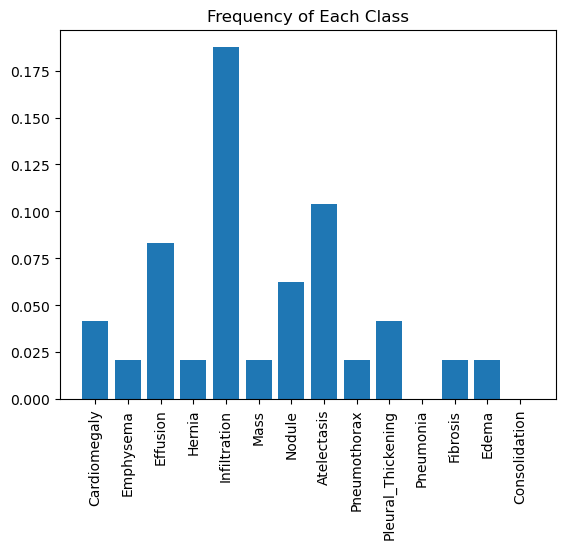

In [82]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [83]:
def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [84]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.04166667, 0.02083333, 0.08333333, 0.02083333, 0.1875    ,
       0.02083333, 0.0625    , 0.10416667, 0.02083333, 0.04166667,
       0.        , 0.02083333, 0.02083333, 0.        ])

C:\Users\Nites\AppData\Local\Temp\ipykernel_7980\2978771470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


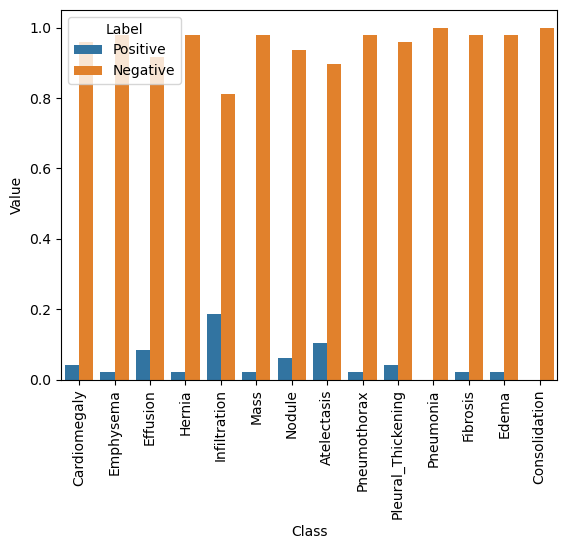

In [85]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [86]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

C:\Users\Nites\AppData\Local\Temp\ipykernel_7980\4211278599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


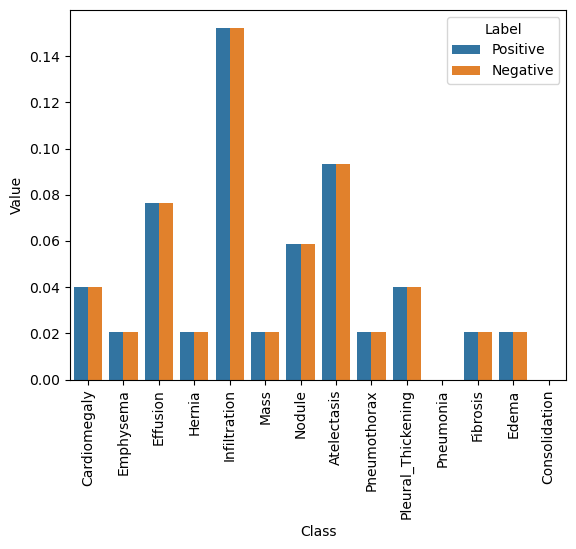

In [87]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [88]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
   
    def weighted_loss(y_true, y_pred):
    
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [89]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
Colocations handled automatically by placer.


<a name='4'></a>
## 4 Training [optional]

**Note** that we have already provided a pre-trained model, so you don't need to run the following training cell (as it will take some time).

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  


In [24]:
# """
# OPTIONAL: uncomment this code to practice training the model.
# This is optional because we have loaded pre-trained weights after this.
# """

history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [90]:
model.load_weights("./nih/pretrained_model.h5")

In [91]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

C:\Users\Nites\AppData\Local\Temp\ipykernel_7980\2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
C:\Users\Nites\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Error in generating ROC curve for Mass. Dataset lacks enough examples.
Error in generating ROC curve for Nodule. Dataset lacks enough examples.


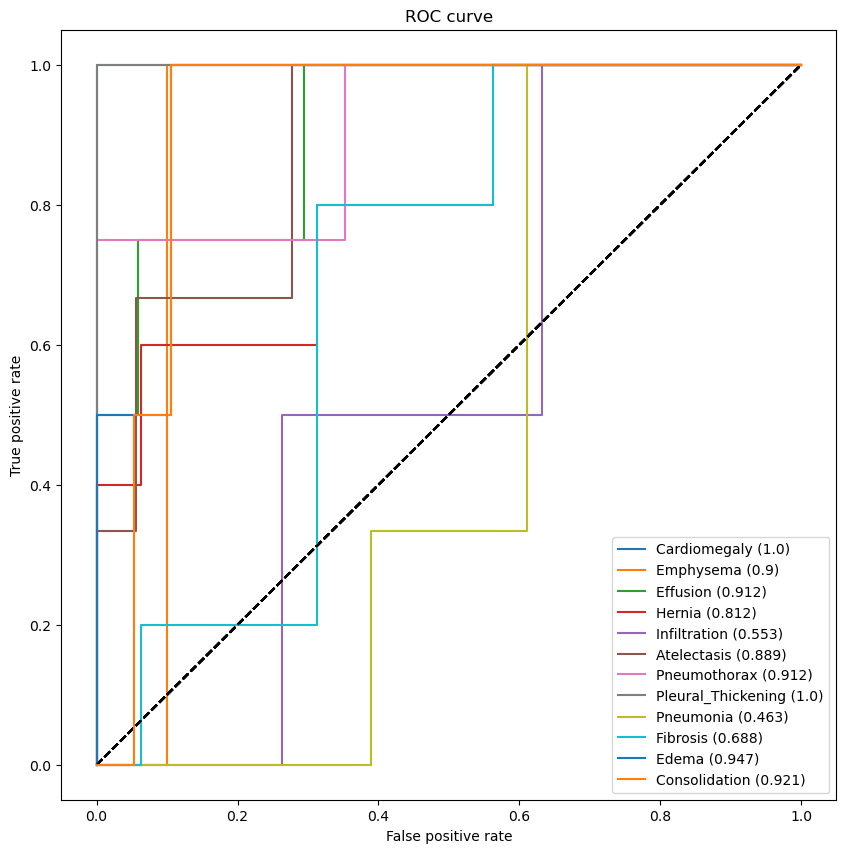

In [92]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [108]:
df = pd.read_csv("train-small.csv")
IMAGE_DIR = "C:\\Users\\Nites\\Downloads\\Disease diagnosis mini project\\images\\"
# IMAGE_DIR = "C:\\Users\\Nites\\OneDrive\\Desktop\\"

lab  = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', ]

lab1 = ['Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',]

lab2 = ['Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis',]

lab3 = [
    'Edema', 
    'Consolidation']

In [119]:
def pred(image):
    util.compute_gradcam(model, image, IMAGE_DIR, df, labels, lab)
    util.compute_gradcam(model, image, IMAGE_DIR, df, labels, lab1)
    util.compute_gradcam(model, image, IMAGE_DIR, df, labels, lab2)
    util.compute_gradcam(model, image, IMAGE_DIR, df, labels, lab3)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Loading original image
Generating gradcam for class Infiltration
Generating gradcam for class Mass
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Loading original image
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Loading original image
Generating gradcam for class Edema
Generating gradcam for class Consolidation


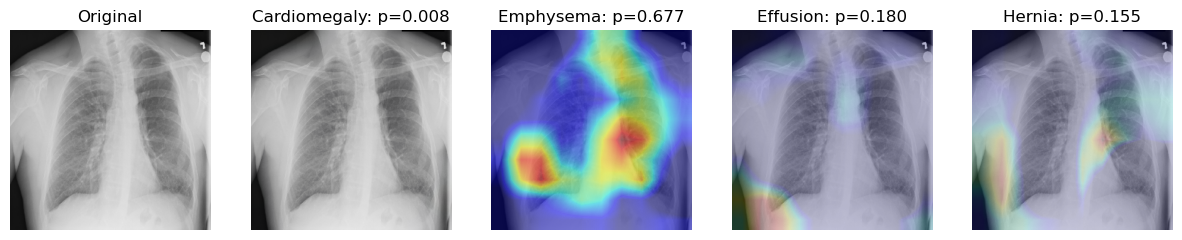

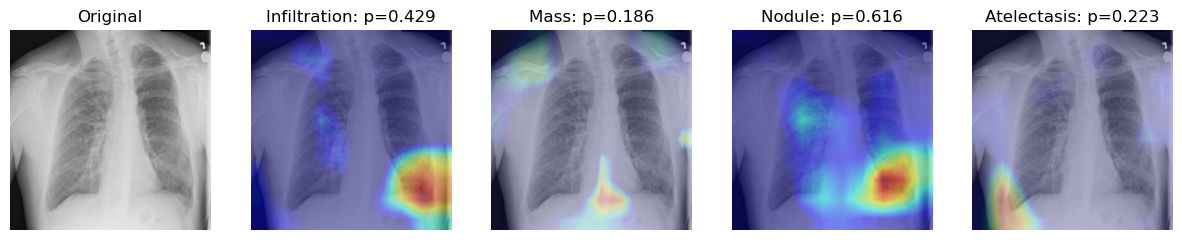

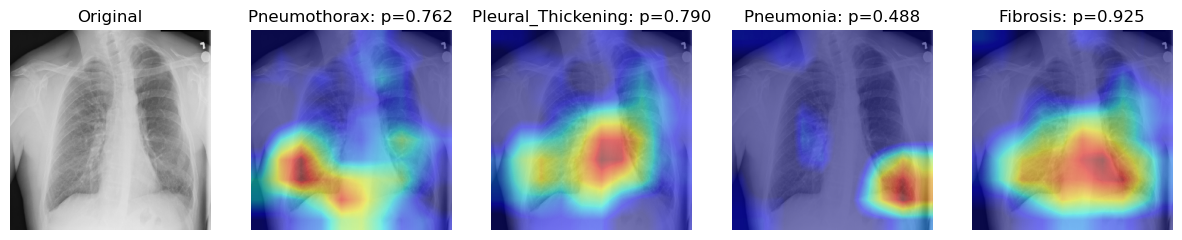

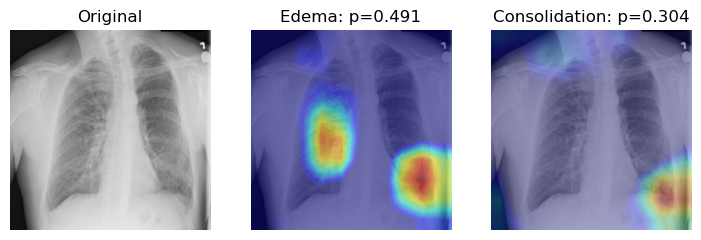

In [120]:
pred('00001315_000.png')

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Emphysema
Generating gradcam for class Effusion
Generating gradcam for class Hernia
Loading original image
Generating gradcam for class Infiltration
Generating gradcam for class Mass
Generating gradcam for class Nodule
Generating gradcam for class Atelectasis
Loading original image
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis
Loading original image
Generating gradcam for class Edema
Generating gradcam for class Consolidation


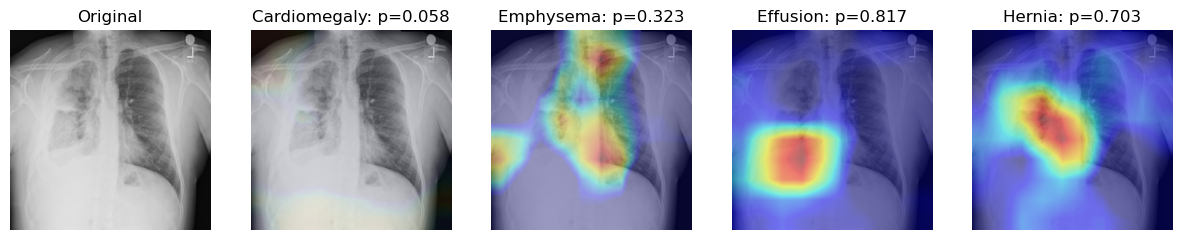

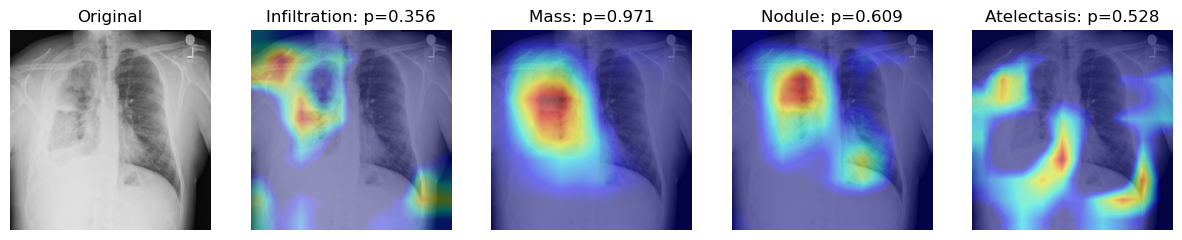

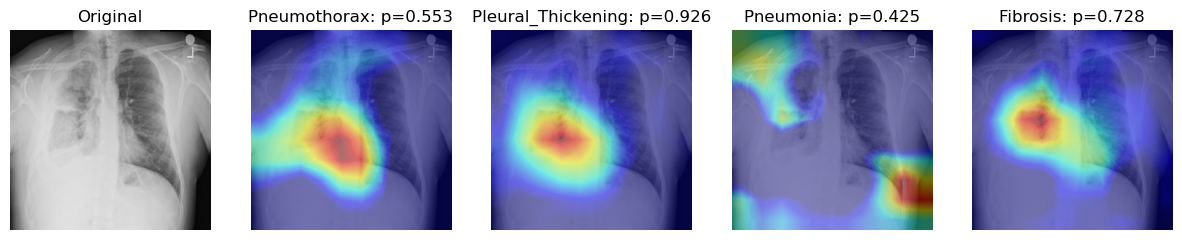

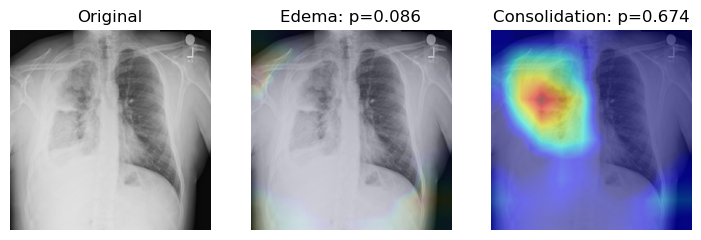

In [113]:
pred('00001314_001.png')

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Atelectasis
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis


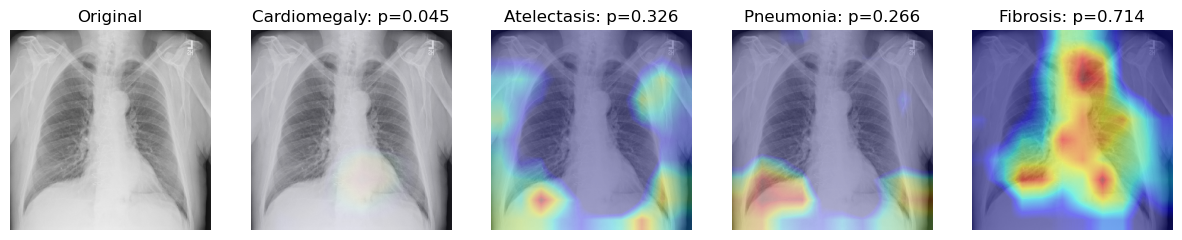

In [97]:
util.compute_gradcam(model, '00001048_000.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Atelectasis
Generating gradcam for class Pneumonia
Generating gradcam for class Fibrosis


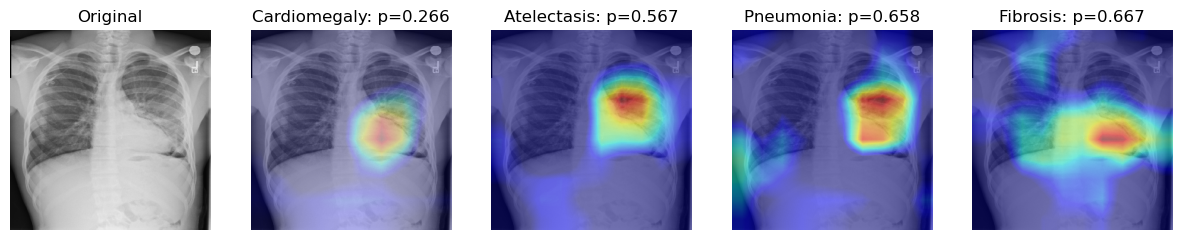

In [98]:
util.compute_gradcam(model, '00000832_005.png', IMAGE_DIR, df, labels, labels_to_show)